In [ ]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from functools import partial
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

sns.set_style('whitegrid')

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_1p(etas, lamb):
  return jnp.mean(etas/(lamb+etas)**2)

def g_1(etas, lamb):
  return jnp.mean(1.0/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-5, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if (abs(f(x_next)) < abs_tol) or (abs(f(x_next)) < rel_tol * gf(x)):
            return x_next
        x = x_next

def bisect(f, xl, xu, max_step=100, abs_tol=1e-5):
    x = (xl + xu)/2
    for _ in range(max_step):
        if (abs(f(x)) < abs_tol):
            return x
        if f(xl)*f(x) < 0:
            xu = x
        else:
            xl = x
        x = (xl + xu)/2
    return x

def estimate_df1p(lamb, X_tr):
    T, N = X_tr.shape
    q = N/T
    if q >= 1:
        gram = X_tr @ X_tr.T / T
        eigs, _ = jnp.linalg.eigh(gram)
        return df_1p(eigs, lamb) * 1/q
    else:
        cov = X_tr.T @ X_tr / T
        eigs, _ = jnp.linalg.eigh(cov)
        return df_1p(eigs, lamb)

def get_df2_fn(df1_fn, S_fn):
    d_df1_fn = grad(df1_fn)
    kappa_fn = lambda lamb: lamb * S_fn(df1_fn(lamb))
    log_kappa_fn = lambda lamb: jnp.log(kappa_fn(lamb))
    d_log_kappa_fn = grad(log_kappa_fn)
    df2_fn = lambda lamb: df1_fn(lamb) + d_df1_fn(lamb)/d_log_kappa_fn(lamb)
    return df2_fn

def S_exp_corr(b, df1):
    return (1 - df1)/(jnp.sqrt(1 + (b**2 - 1) * (df1)**2) - b*df1)

def S_nn_corr(b, df1):
    return (jnp.sqrt(1 - b**2*df1*(2 - df1)) - (1 - df1) )/((1 - b**2)*df1 )

def get_kappa(df1_fn, df1, lower=0.0, upper=1e8, **kwargs):
    fn = lambda lamb: df1_fn(lamb) - df1
    return bisect(fn, xl=lower, xu=upper, **kwargs)

def get_S(df1_fn, df1, **kwargs):
    kappa = get_kappa(df1_fn, df1, **kwargs)
    return (1-df1)/(df1*kappa)

def toeplitz(entries):
    n = len(entries)
    indices = np.arange(n)
    return entries[np.abs(indices[:, None] - indices)]

def matrix_sqrt_svd(A):
    U, s, Vt = jnp.linalg.svd(A, full_matrices=False)
    return U @ jnp.diag(jnp.sqrt(s)) @ Vt

In [ ]:
def generate_correlated_sample(T_te, X, K_ch, k, Sigma, seed):
    alpha = jax.scipy.linalg.solve_triangular(K_ch, k, lower=True)
    alpha = jax.scipy.linalg.solve_triangular(K_ch.T, alpha, lower=False)

    mu_cond = X.T @ alpha
    rho = 1 - jnp.dot(k, alpha)
    Sigma_cond = rho * Sigma

    X_te = jnp.tile(mu_cond, (T_te, 1)) + random.normal(seed, (T_te, N)) @ (Sigma_cond**0.5)
    return X_te

def generate_correlated_noise(T_te, eps, L, k, sigma_eps, seed):
    alpha = jax.scipy.linalg.solve_triangular(L, k, lower=True)
    alpha = jax.scipy.linalg.solve_triangular(L.T, alpha, lower=False)
    mu_cond = jnp.dot(eps, alpha)
    rho = 1 - jnp.dot(k, alpha)
    sigma_eps_cond = rho * sigma_eps

    X_te = jnp.ones(T_te) * mu_cond + random.normal(seed, (T_te, )) * sigma_eps_cond
    return X_te

def simulate_theory(N, Ts, lambs, sigma_epsilon, spectrum_X, K_chs, teacher, T_test, num_X_seeds, S_fn=None, uncorrelated_noise=False, corr_fn=None, compute_CV=False):
    if not S_fn:
        S_fn = lambda df: 1.0
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    data = {}

    Sigma = jnp.diag(spectrum_X)

    X_te_key, eps_te_key = random.split(random.PRNGKey(42))
    if corr_fn is None:
        X_te = random.normal(X_te_key, (T_te, N)) @ jnp.sqrt(Sigma)
        y_te = X_te @ teacher
        y_out = y_te + random.normal(eps_te_key, (T_te, )) * sigma_epsilon


    for i in tqdm(range(len(Ts))):
        T, lamb = Ts[i], lambs[i]
        q = N/T

        if K_chs:
            K_ch = K_chs[i]
        else:
            K_ch = np.eye(T)

        y_hats = np.zeros((num_X_seeds, T_test))
        y_hats_clean = np.zeros((num_X_seeds, T_test))
        df1_Sh, df1_Kh = np.zeros(num_X_seeds), np.zeros(num_X_seeds)
        df2_Sh, df2_Kh = np.zeros(num_X_seeds), np.zeros(num_X_seeds)
        kappa_GCV, kappa2_GCV = np.zeros(num_X_seeds), np.zeros(num_X_seeds)
        Etrs = np.zeros(num_X_seeds)
        E_GCV, E_GCV_naive, E_GCV_naive2, E_GCV_naive3 = np.zeros(num_X_seeds), np.zeros(num_X_seeds), np.zeros(num_X_seeds), np.zeros(num_X_seeds)
        spectra_Sh = np.zeros((num_X_seeds, N))
        y_tests = np.zeros((num_X_seeds, T_test))
        y_outs = np.zeros((num_X_seeds, T_test))
        for X_seed in range(num_X_seeds):
            key = random.PRNGKey(X_seed)
            X_tr_key, e_key = random.split(key)

            X_tr = K_ch @ random.normal(X_tr_key, (T, N)) @ (Sigma**0.5)
            if uncorrelated_noise:
                eps_tr = random.normal(e_key, (T, )) * sigma_epsilon
            else:
                eps_tr = K_ch @ random.normal(e_key, (T, )) * sigma_epsilon

            y_tr = X_tr @ teacher + eps_tr
            y_tr_clean = X_tr @ teacher

            if corr_fn is not None:
                k_vec = corr_fn(jnp.arange(1, T+1))
                X_te = generate_correlated_sample(T_test, X_tr, K_ch, k_vec, Sigma, X_te_key)
                y_te = X_te @ teacher
                if uncorrelated_noise:
                    eps_te = random.normal(eps_te_key, (T_te, )) * sigma_epsilon
                else:
                    eps_te = generate_correlated_noise(T_test, eps_tr, K_ch, k_vec, sigma_epsilon, eps_te_key)
                y_out = y_te + eps_te
            y_tests[X_seed, :] = y_te
            y_outs[X_seed, :] = y_out

            if T > N:
                cov = X_tr.T @ X_tr/T
                w_star = jnp.linalg.solve(cov + lamb*np.identity(N), X_tr.T @ y_tr/T)
                w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(N), X_tr.T @ y_tr_clean/T)
                y_hat_tr = X_tr @ w_star
                Etrs[X_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                spectrum_Sh = jnp.linalg.eigvalsh(np.array(cov, dtype=np.float64))[::-1]
            else:
                gram = X_tr @ X_tr.T/T
                w_star = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(T), y_tr)/T
                w_star_clean = X_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(T), y_tr_clean)/T
                Etrs[X_seed] = lamb**2/T * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(T), y_tr))**2)
                spectrum_Sh = jnp.linalg.eigvalsh(np.array(gram, dtype=np.float64))[::-1]
                spectrum_Sh = jnp.concatenate([spectrum_Sh, jnp.zeros(N - T)])

            y_hats[X_seed, :] = X_te @ w_star
            y_hats_clean[X_seed, :] = X_te @ w_star_clean
            spectra_Sh[X_seed, :] = spectrum_Sh

            df1_fn_Sh = lambda l: df_1(spectrum_Sh, l)
            df1_est = df1_fn_Sh(lamb)
            df1_Sh[X_seed] = df1_est
            df1_Kh[X_seed] = q*df1_est

            S_est = 1/(1-q*df1_est)
            E_GCV_naive[X_seed] = Etrs[X_seed]*S_est**2
            S_est = S_est * S_fn(q*df1_est)
            E_GCV_naive2[X_seed] = Etrs[X_seed]*S_est**2
            kappa_GCV[X_seed] = lamb * S_est
            kappa2_GCV[X_seed] = lamb/(kappa_GCV[X_seed]*q*df1_est)

            d_df1_fn_Sh = grad(df1_fn_Sh)
            S_fn_full = lambda df: 1/(1-q*df) * S_fn(q*df)
            k1_fn = lambda l: l * S_fn_full(df1_fn_Sh(l))
            log_k1_fn = lambda l: jnp.log(k1_fn(l))
            d_log_k1_fn = grad(log_k1_fn)

            k2_fn = lambda l: l/(q * df1_fn_Sh(l) * k1_fn(l))
            log_k2_fn = lambda l: jnp.log(k2_fn(l))
            d_log_k2_fn = grad(log_k2_fn)

            df2_fn_Sh = lambda lamb: df1_fn_Sh(lamb) + d_df1_fn_Sh(lamb)/d_log_k1_fn(lamb)
            df2_Sh_est = df2_fn_Sh(lamb)
            for _ in range(1):
                df2_Kh_est = q*df1_est - q*(df1_fn_Sh(lamb) -  df2_Sh_est)*d_log_k1_fn(lamb)/d_log_k2_fn(lamb)
                df2_Sh_est = df1_est - 1/q * (q*df1_est - df2_Kh_est)*d_log_k2_fn(lamb)/d_log_k1_fn(lamb)
            df2_Sh[X_seed] = df2_Sh_est
            df2_Kh[X_seed] = df2_Kh_est
            E_GCV[X_seed] =  Etrs[X_seed]*S_est*df1_Kh[X_seed]/(df1_Kh[X_seed] - df2_Kh[X_seed])

            gamma = df2_Sh[X_seed]*df2_Kh[X_seed]/(df1_Sh[X_seed]*df1_Kh[X_seed])

            E_GCV_naive3[X_seed] = Etrs[X_seed]*(S_est*df1_Kh[X_seed]/(df1_Kh[X_seed] - df2_Kh[X_seed]))**2 * (1-gamma)**2


        Eout = np.mean((y_hats - y_outs)**2, axis=-1)
        Eg = np.mean((y_hats - y_tests)**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_tests)**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        # Bias and variance only make sense when test point is uncorrelated
        Bias = np.mean((y_te - np.mean(y_hats_clean, axis=0))**2)
        VarX = np.mean((y_hats_clean - y_tests)**2, axis=-1) - Bias
        VarXe = Noise
        data[T] = {
            'Eout': np.mean(Eout),
            'Eout_std': np.std(Eout),
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': Noise,
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1_Sh': np.mean(df1_Sh),
            'df1_Sh_std': np.std(df1_Sh),
            'df1_Kh': np.mean(df1_Kh),
            'df1_Kh_std': np.std(df1_Kh),
            'df2_Sh': np.mean(df2_Sh),
            'df2_Sh_std': np.std(df2_Sh),
            'df2_Kh': np.mean(df2_Kh),
            'df2_Kh_std': np.std(df2_Kh),
            'k1_GCV': np.mean(kappa_GCV),
            'k1_GCV_std': np.std(kappa_GCV),
            'k2_GCV': np.mean(kappa2_GCV),
            'k2_GCV_std': np.std(kappa2_GCV),
            'E_GCV': np.mean(E_GCV),
            'E_GCV_std': np.std(E_GCV),
            'E_GCV_naive': np.mean(E_GCV_naive),
            'E_GCV_naive_std': np.std(E_GCV_naive),
            'E_GCV_naive2': np.mean(E_GCV_naive2),
            'E_GCV_naive2_std': np.std(E_GCV_naive2),
            'E_GCV_carmack': np.mean(E_GCV_naive3),
            'E_GCV_carmack_std': np.std(E_GCV_naive3),
            'spectra_Sh': spectra_Sh,
        }
    dataT = {}
    for key in data[Ts[0]]:
        dataT[key] = np.array([data[T][key] for T in data])
    return dataT


def solve_kappa_correlated(q, lamb, df1_fn, S_fn=None, upper_bound=None, anneal_steps=1, **kwargs):
    if not upper_bound:
        upper_bound = lamb + 1e3
    if not S_fn:
        # Default to white Wishart:
        S_fn = lambda df: 1.0
    if lamb == 0 and q <= 1:
        return 0
    if lamb == 0 and q > 1:
        fn = lambda k: 1 - q * df1_fn(k)
        return newton(fn, x0=0.0, **kwargs)

    # anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
    anneal_schedule = np.linspace(0, q, num=anneal_steps+1)
    kappa = upper_bound
    for anneal_q in anneal_schedule:
        fn = lambda k: k * (1 - anneal_q * df1_fn(k))/S_fn(anneal_q*df1_fn(k)) - lamb
        kappa_next = newton(fn, x0=kappa, **kwargs)
        if not kappa_next:
            print("Annealing didn't find kappa. Returning last value.")
            return kappa
        kappa = kappa_next
    return kappa

def solve_theory(qs, lambs, sigma_epsilon, spectrum_S, spectrum_K, S_fn, teacher, spectrum_Kns=None, uncorrelated_noise=False, self_consistent_steps=10,  anneal_steps=0, corr_fn=None, Kchs=None, **kwargs):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    if type(anneal_steps) != list:
        anneal_steps = np.array([anneal_steps]*len(qs))
    upper_bounds = lambs + np.mean(spectrum_S)*qs
    df1_fn = lambda k: df_1(spectrum_S, k)

    k1 = lambs #jnp.array([solve_kappa_correlated(q, lamb, df1_fn, S_fn,
                #   anneal_steps=an, upper_bound=bd, **kwargs)
                #  for q, lamb, bd, an in zip(qs, lambs, upper_bounds, anneal_steps)])
    df1_S = jnp.array([df_1(spectrum_S, k) for k in k1])
    k2 = lambs/(k1 * qs * df1_S)
    df1_K = jnp.array([df_1(spectrum_K, k) for k in k2])
    for _ in range(self_consistent_steps):
        k1 = lambs/(k2 * df1_K)
        df1_S = jnp.array([df_1(spectrum_S, k) for k in k1])
        k2 = lambs/(k1 * qs * df1_S)
        df1_K = jnp.array([df_1(spectrum_K, k) for k in k2])

    df2_S = jnp.array([df_2(spectrum_S, k) for k in k1])
    df2_K = jnp.array([df_2(spectrum_K, k) for k in k2])
    if uncorrelated_noise:
        df2_KKn = jnp.array([df_1p(spectrum_K, k) for k in k2])
        df1_KKn = jnp.array([g_1(spectrum_K, k) for k in k2])
    else:
        df2_KKn = df2_K
        df1_KKn = df1_K

    S1 = k1/lambs
    S2 = k2/lambs
    gamma = qs * (lambs * S1 * S2)**2 * df2_S * df2_K
    gamma_n = qs * (lambs * S1 * S2)**2 * df2_S * df2_KKn
    GCV = S1 / (1 - df2_K/df1_K)

    tf1p = jnp.array([tf_1p(spectrum_S, teacher, k) for k in k1])

    bias = k1**2 * tf1p
    varX = k1**2 * tf1p * gamma/(1-gamma)
    noise = sigma_epsilon**2 * gamma_n/(1-gamma)
    signal = bias + varX
    Eg = signal + noise
    Etr = signal/GCV + sigma_epsilon**2/S1 * (df2_KKn/df1_K*(df2_S/df1_S - 1) /(1-gamma) + df1_KKn/df1_K)
    Eout = Eg + sigma_epsilon**2
    if corr_fn is not None:
        assert Kchs is not None
        Ts = [Kch.shape[0] for Kch in Kchs]
        k_vecs = [corr_fn(jnp.arange(1, T+1)) for T in Ts]
        alphas = [jax.scipy.linalg.solve_triangular(L, k_vec, lower=True) for k_vec, L in zip(k_vecs, K_chs)]
        rho = np.array([jnp.sum(alpha**2) for alpha in alphas])
        Ks = [Kch @ Kch.T for Kch in Kchs]
        corrs1 = [jnp.linalg.solve(K + k * np.eye(T), alpha) for K, alpha, k, T in zip(Ks, alphas, k2, Ts)]
        corrs2 = [jnp.linalg.solve(K + k * np.eye(T), corr) for K, corr, k, T in zip(Ks, corrs1, k2, Ts)]
        corrs3 = np.array([np.dot(k_vec, c) for k_vec, c in zip(k_vecs, corrs2)]) * (k2**2)
        corr = 1-rho + corrs3


        Eg = Eg * corr
        if uncorrelated_noise is False:
            Eout = Eg + sigma_epsilon**2 * corr
        else:
            Eout = Eg + sigma_epsilon**2


    data = {
        'k1': k1,
        'k2': k2,
        'df1_S': df1_S,
        'df1_K': df1_K,
        'S1': S1,
        'S2': S2,
        'df2_S': df2_S,
        'df2_K': df2_K,
        'tf1p': tf1p,
        'gamma': gamma,
        'Bias': bias,
        'VarX': varX,
        'VarXe': noise,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr,
        'Eout': Eout
    }
    return data

In [ ]:
N = 100
T_te = 100
qs = np.logspace(-1, 1, 15)
qs2 = np.logspace(-1, 1, 25)
Ts = (N/qs).astype(int)
Ts2 = (N/qs2).astype(int)
qs = N/Ts

xi = 0.5
lamb = 1e-5
sigma_epsilon = 0.0 #3e-2
num_X_seeds = 10
alpha = 1.2 #1.8 # 1.5
r = 0.8 # 0.3 #0.2
beta = alpha * (r-1/2) + 1/2 if r > 0.0 else 0.0
# a =  2 beta + alpha = 2 alpha r + 1
uncorrelated_noise=False

corr_type = 'nn'
if corr_type == 'exp':
    b = 1/np.tanh(1/xi)
    S_fn = lambda df1: S_exp_corr(b, df1)
    mat_fn = lambda T, xi: toeplitz(np.exp(-np.arange(T)/xi))
elif corr_type == 'nn':
    b = xi
    S_fn = lambda df1: S_nn_corr(b, df1)
    mat_fn = lambda T, b: toeplitz(np.array([1, b/2] + [0]*(T-2)))
elif corr_type == 'power':
    print("not implemented")

In [ ]:
K_chs = []
spectrum_Ks = []
for T in tqdm(Ts):
    K = mat_fn(T, xi)
    K_chs.append(jnp.linalg.cholesky(K, upper=False))
    spectrum_Ks.append(jnp.linalg.eigvalsh(np.array(K, dtype=np.float64))[::-1])

spectrum_X = jnp.arange(1, N+1)**(-alpha)
Sigma = jnp.diag(spectrum_X)
w = jnp.arange(1, N+1)**(-beta)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(42)
X_te = random.normal(X_te_key, (T_te, N)) @ jnp.sqrt(Sigma)
y_te = X_te @ w

tau = 1000
corr_fn = lambda t: jnp.exp(-(t+tau)/xi)

expt = simulate_theory(N, Ts, lamb, sigma_epsilon, spectrum_X, K_chs, w, T_te, num_X_seeds, S_fn=S_fn, uncorrelated_noise=False, corr_fn=corr_fn)

K_chs = []
spectrum_Ks = []
for T in tqdm(Ts2):
    K = mat_fn(T, xi)
    K_chs.append(jnp.linalg.cholesky(K, upper=False))
    spectrum_Ks.append(jnp.linalg.eigvalsh(np.array(K, dtype=np.float64))[::-1])
thry = solve_theory(qs2, lamb, sigma_epsilon, spectrum_X, spectrum_Ks[0], S_fn, w, anneal_steps=5, self_consistent_steps=100, uncorrelated_noise=uncorrelated_noise)

100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


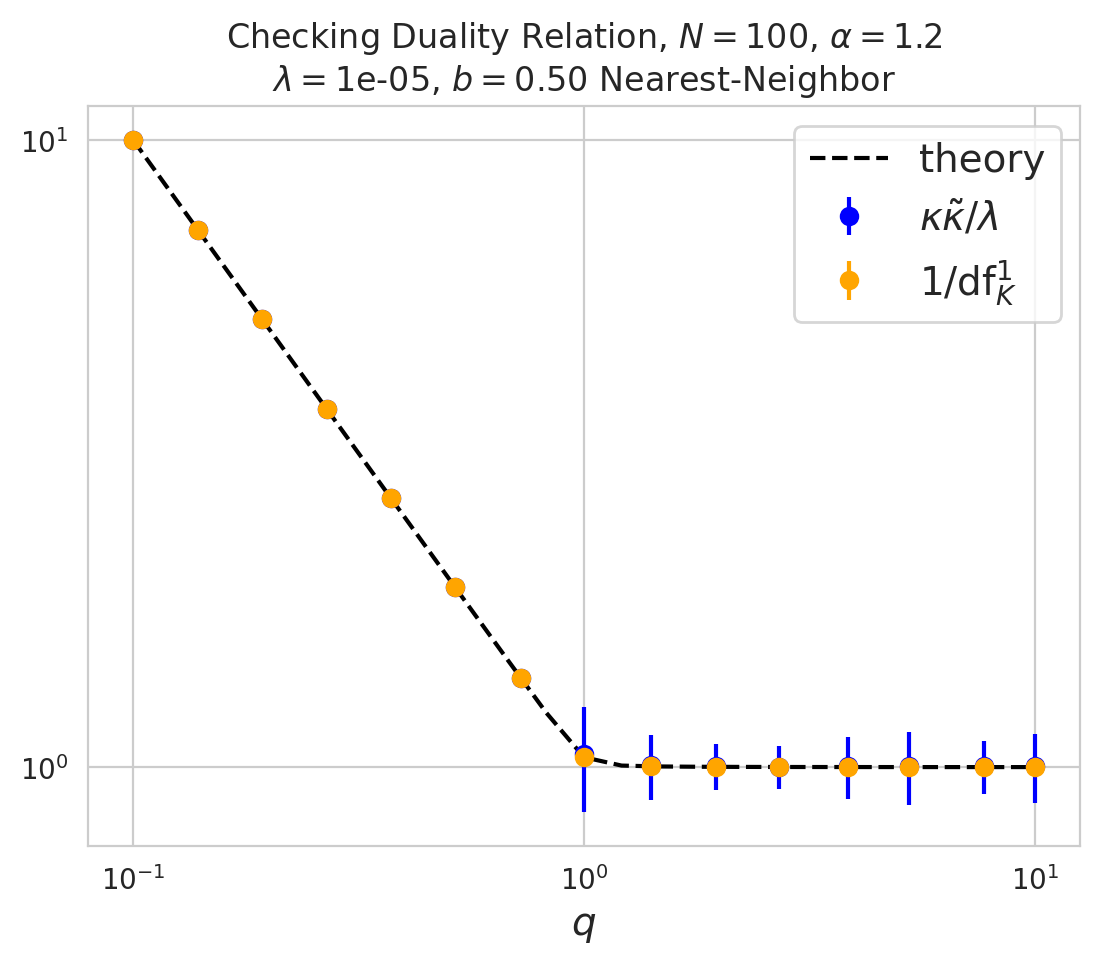

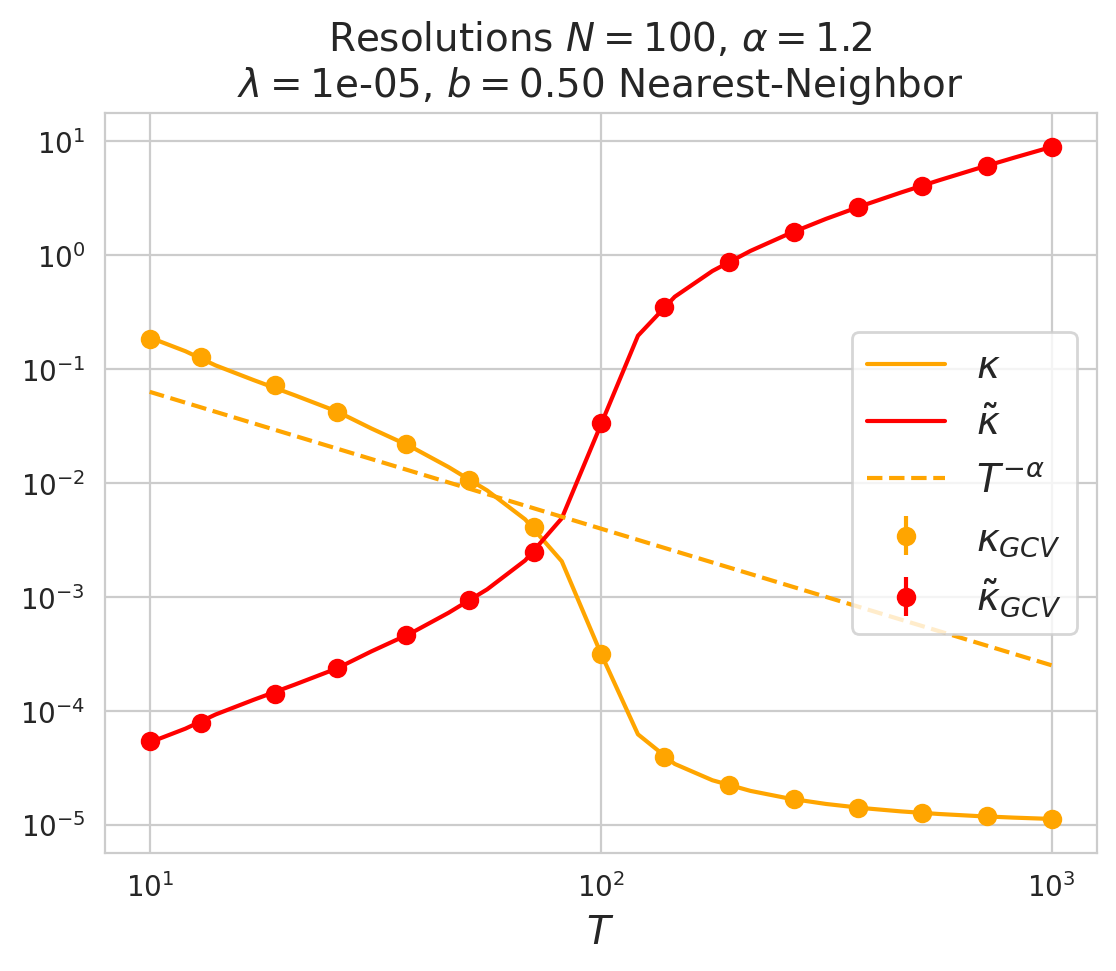

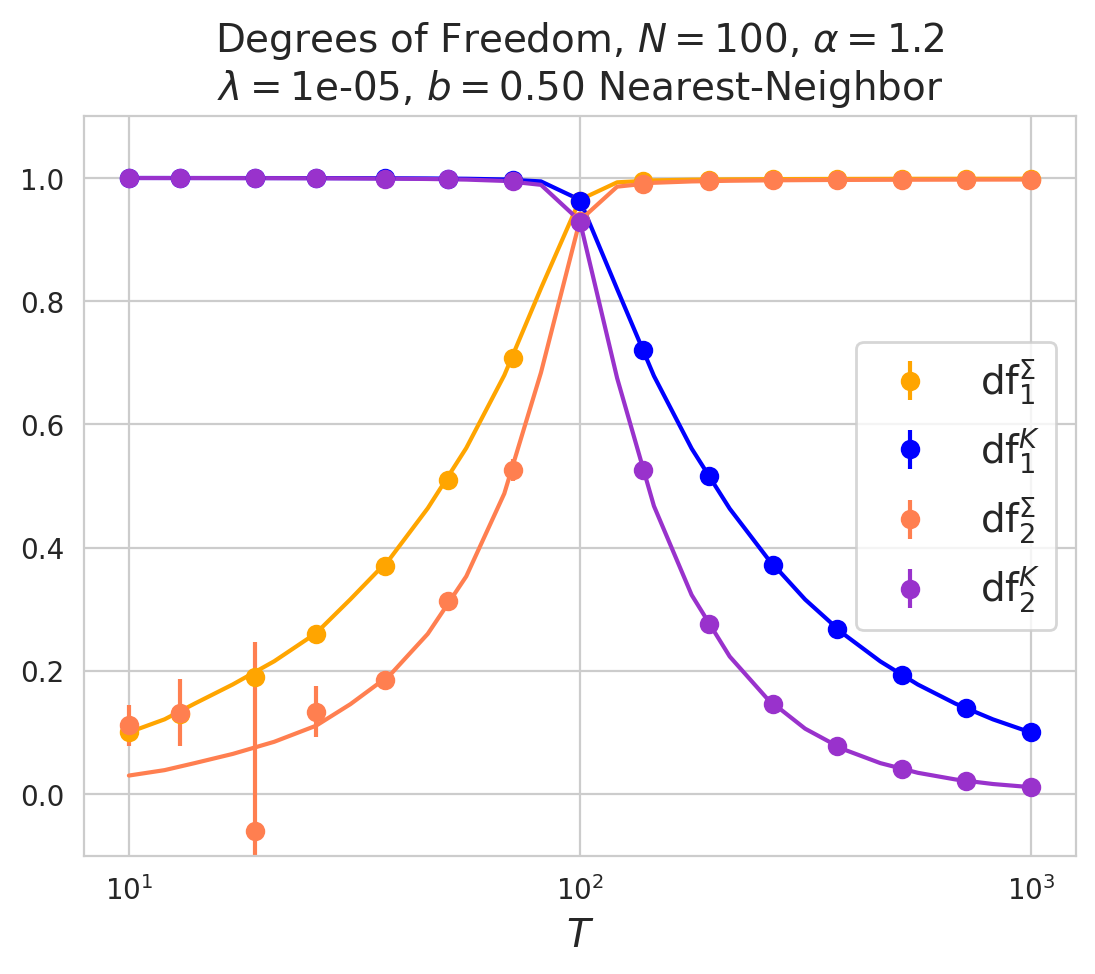

In [ ]:
if alpha > 0:
    title = f"Checking Duality Relation, $N=${N}, $\\alpha=${alpha:.1f}\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
else:
    title = f"Checking Duality Relation, $N=${N}, Isotropic Data\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
plt.title(title)
plt.errorbar(qs, expt['k1_GCV']*expt['k2_GCV']/lamb, (expt['k1_GCV_std']*expt['k2_GCV']+expt['k1_GCV']*expt['k2_GCV_std'])/lamb, marker='o', ls='', color='blue', label="$\\kappa \\tilde \\kappa/\\lambda$")
plt.errorbar(qs, 1/(qs*expt['df1_Sh']),  1/(qs*expt['df1_Sh']**2)*expt['df1_Sh_std'], marker='o', ls='', color='orange', label='$1/\\mathrm{df}^1_{K}$')
plt.plot(qs2, 1/(thry['df1_K']), c='black', ls='--', label='theory')
plt.loglog()
plt.legend(fontsize=14)
plt.xlabel("$q$", fontsize=14)
plt.savefig(f'figures/duality_relation_{corr_type}_N={N}_l={lamb:.0e}_xi={xi:.0e}_a={alpha:.1f}.pdf', bbox_inches='tight')
plt.show()

if alpha > 0:
    title = f"Resolutions $N=${N}, $\\alpha=${alpha:.1f}\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
else:
    title = f"Resolutions, $N=${N}, Isotropic Data\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
plt.title(title, fontsize=14)
plt.plot(Ts2, thry['k1'], '-', color='orange', label="$\\kappa$")
plt.errorbar(Ts, expt['k1_GCV'],  expt['k1_GCV_std'], marker='o', ls='', color='orange', label="$\\kappa_{GCV}$")
plt.plot(Ts2, thry['k2'], '-', color='red', label="$\\tilde \\kappa$")
plt.errorbar(Ts, expt['k2_GCV'], expt['k2_GCV_std'], marker='o', ls='',  color='red', label="$\\tilde \\kappa_{GCV}$")
plt.xlabel('$T$', fontsize=14)
if alpha > 0:
    plt.plot(Ts2, Ts2**(-alpha), c='orange', ls='--', label="$T^{-\\alpha}$")
plt.loglog()
plt.legend(fontsize=14)
plt.savefig(f'figures/res_{corr_type}_N={N}_l={lamb:.0e}_xi={xi:.0e}_a={alpha:.1f}.pdf', bbox_inches='tight')
plt.show()

if alpha > 0:
    title = f"Degrees of Freedom, $N=${N}, $\\alpha=${alpha:.1f}\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
else:
    title = f"Degrees of Freedom, $N=${N}, Isotropic Data\n$\\lambda=${lamb:.0e}, $b=${xi:.2f} Nearest-Neighbor"
plt.title(title, fontsize=14)

plt.plot(Ts2, thry['df1_S'], color='orange')
plt.errorbar(Ts, expt['df1_Sh'], expt['df1_Sh_std'], marker='o', ls='', color='orange', label="df$_1^{\\Sigma}$")
plt.plot(Ts2, qs2*thry['df1_S'], color='blue')
plt.errorbar(Ts, qs*expt['df1_Sh'], qs*expt['df1_Sh_std'], marker='o', ls='', color='blue', label="df$_1^{K}$")
plt.plot(Ts2, thry['df2_S'], color='coral')
plt.errorbar(Ts, expt['df2_Sh'],  expt['df2_Sh_std'],  marker='o', ls='', color='coral', label="df$_2^{\\Sigma}$")
plt.plot(Ts2, thry['df2_K'], color='darkorchid')
plt.errorbar(Ts, expt['df2_Kh'],  expt['df2_Kh_std'],  marker='o', ls='', color='darkorchid', label="df$_2^K$")

plt.ylim(-0.1, 1.1)
plt.xscale('log')
plt.xlabel("$T$", fontsize=14)
# plt.yscale('log')
plt.legend(fontsize=14)
plt.savefig(f'figures/df_{corr_type}_N={N}_l={lamb:.0e}_xi={xi:.0e}_a={alpha:.1f}.pdf', bbox_inches='tight')

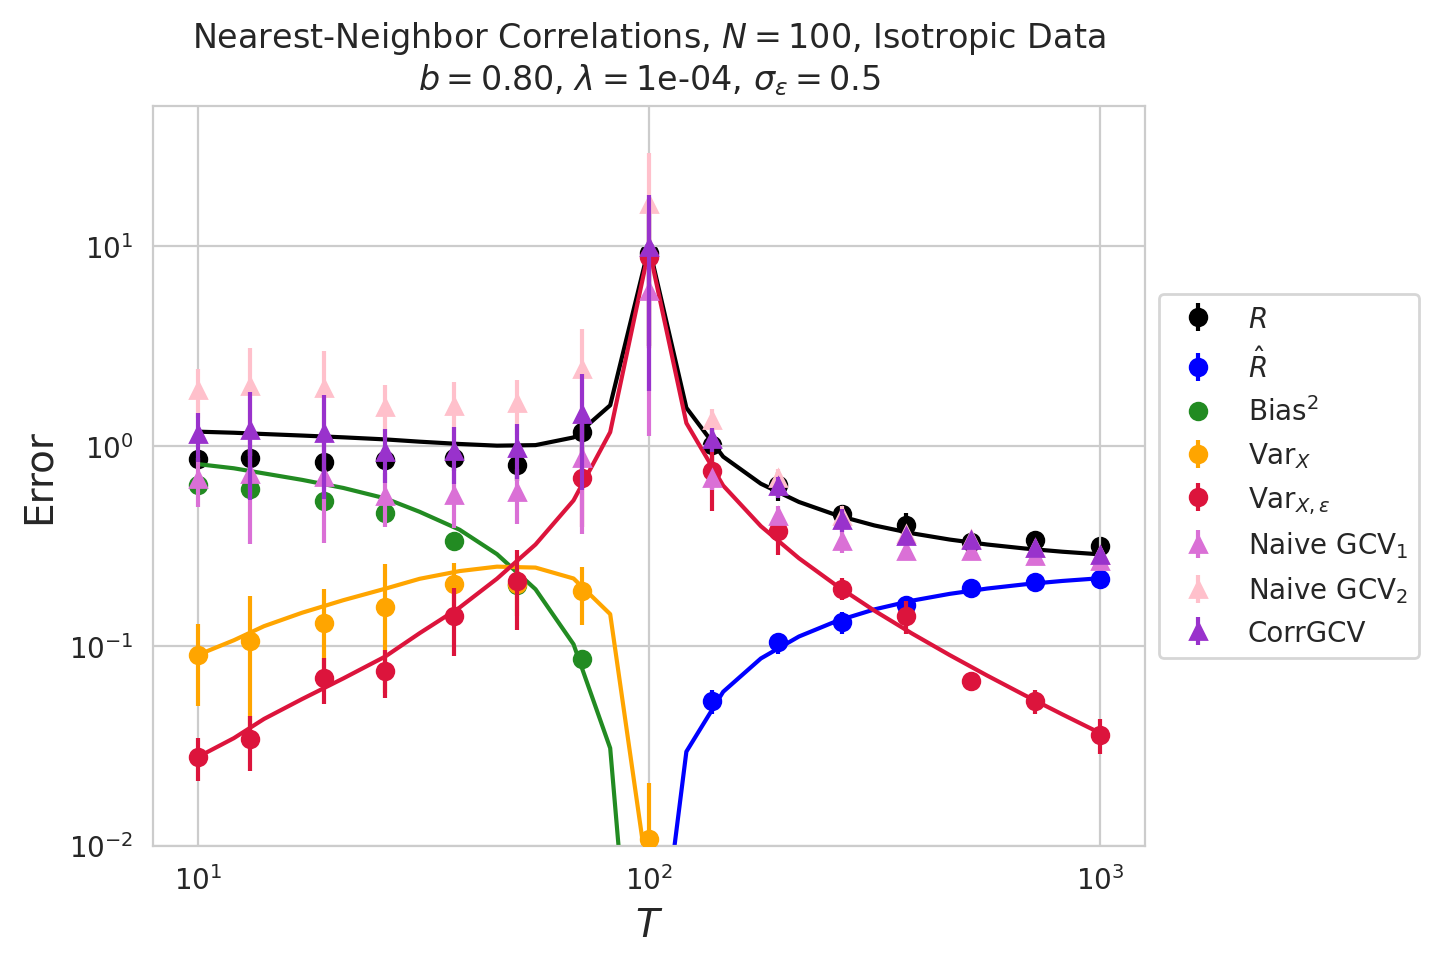

In [ ]:
keys = ['Eout', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$R$", "$\hat R$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(Ts, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label, zorder=i)
    else:
        plt.plot(Ts, expt[key], c=color, marker='o', linestyle='', label=label, zorder=i)
    plt.plot(Ts2, thry[key], c=color)

plt.errorbar(Ts, expt['E_GCV_naive'], expt['E_GCV_naive_std'], c='orchid', marker='^', linestyle='', label='Naive GCV$_1$', zorder=i)
plt.errorbar(Ts, expt['E_GCV_naive2'], expt['E_GCV_naive2_std'], c='pink', marker='^', linestyle='', label='Naive GCV$_2$', zorder=i)
plt.errorbar(Ts, expt['E_GCV'], expt['E_GCV_std'], c='darkorchid', marker='^', linestyle='', label='CorrGCV', zorder=100)



handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0, 3, 4, 5, 6, 7]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel(r'$T$', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 5e1)
if alpha > 0:
    title = f"Nearest-Neighbor Correlations $N=${N} $\\alpha$={alpha}, $r=${r:.1f}\n"
else:
    title = f"Nearest-Neighbor Correlations, $N=${N}, Isotropic Data\n"
title += f"$b=${xi:.2f}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}"
if uncorrelated_noise:
    title += "\n(uncorrelated noise)"
plt.title(title)
plt.savefig(f'figures/correlated_LR_logspace_{corr_type}_N={N}_l={lamb:.0e}_xi={xi:.2f}_e={sigma_epsilon:.0e}_a={alpha:.1f}_r={r:.1f}.pdf', bbox_inches='tight')